## Neural Networks

**Student:** Guillem Amat (ga98), Sebastián Soriano Pérez (ss1072)

### Importing Packages

In [623]:
# Usual packages
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

In [624]:
# Torch packages
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [625]:
from gen_xor import gen_xor

<br>

### Q1: Multi-Layer Neural Network

Build a multi-layer neural network using PyTorch. Use it to solve the XOR classification problem generated by gen_xor.py. Visualize the decision surface using matplotlib, with the training data overlaid as in Tensorflow Playground.

**XOR Data**

In [626]:
X, y = gen_xor()

Text(0.5, 1.0, 'XOR Distributed Data')

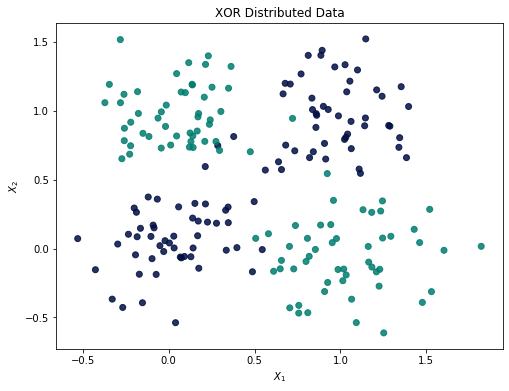

In [627]:
# Plotting the data
plt.figure(figsize = (8, 6))

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = ListedColormap(['#000E43', '#007D6F']), alpha = 0.85)
plt.xlabel('$X_{1}$')
plt.ylabel('$X_{2}$')
plt.title('XOR Distributed Data')

<br>

**Neural Network Architecture**

In [628]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10, False)
        self.fc2 = nn.Linear(10, 5, False)
        self.fc3 = nn.Linear(5,  1, False)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [629]:
# Initializing Neural Network
XOR_net = Net()

In [630]:
# Choosing our Loss Function. We could also use nn.MSELoss or nn.BCELoss.
criterion = nn.BCEWithLogitsLoss()

In [631]:
# Choosing Adam to be our optimizer
optimizer = torch.optim.Adam(XOR_net.parameters(), lr=0.001)

<br>

**Training Neural Network**

In [632]:
# We will divide the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [633]:
X_train.shape, y_train.shape

((160, 2), (160,))

In [634]:
X, y = torch.from_numpy(X), torch.from_numpy(y)
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [635]:
for epoch in tqdm(range(1000)):
    # Set all gradients to zero
    optimizer.zero_grad()
    
    # Propagate the network forward 
    y_hat = XOR_net(X_train.float())
    
    # Get the loss and take a gradient step
    loss = criterion(y_hat, y_train)
    loss.backward()
    
    # Print loss
    if epoch % 500 == 0:
        print(loss)
    
    optimizer.step()

tensor(0.7227, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6111, dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)



In [636]:
with torch.no_grad():
    # Load model
    XOR_net.eval()
    
    # Propagate the network forward
    scores = XOR_net(X_test.float())
    #loss = criterion(y, y_test)
    
    # Get predictions
    predictions = torch.round(scores)

<br>

**Decision boundary**

In [637]:
# Set up Color Map
cmap_light = ListedColormap(['#BCECFF', '#ABE2E0'])
cmap_strong = ListedColormap(['#000E43', '#007D6F'])

In [638]:
def plot_decision_boundary(model, X):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1)
    # Load model
    XOR_net.eval()

    # Propagate the network forward
    y_hat = XOR_net(grid.float())
    Z = torch.round(y_hat.topk(1,1,True,True)[0])
    Z = Z.view(xx.size()).detach().numpy()
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=cmap_light)

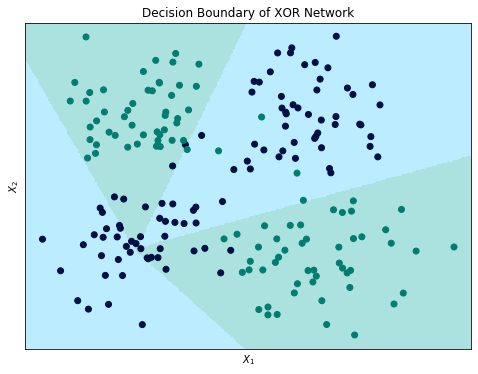

In [639]:
# Plotting decision boundary
plt.figure(figsize = (8, 6))

# Plotting results
plot_decision_boundary(XOR_net, X)
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.numpy().ravel(), cmap=cmap_strong)
plt.scatter(X[:, 0], X[:, 1], c=y.numpy().ravel(), cmap=cmap_strong)
plt.xlabel('$X_{1}$')
plt.ylabel('$X_{2}$')
plt.title('Decision Boundary of XOR Network')

#Removing axis ticks
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.show()

<br>

**Accuracy Computation**

In [640]:
class style:
    start = '\033[1m'
    end = '\033[0m'

In [641]:
accuracy = torch.sum(predictions == y_test) / torch.Tensor([len(predictions)])
accuracy = accuracy.numpy()[0]*100

In [642]:
print(style.start + 'Accuracy: ' + style.end + f'{accuracy.round(2)}%')

Accuracy: 92.5%


<br>

**Saving the Model**

In [643]:
torch.save(XOR_net, 'XOR_net')

<br>

### Q2: Forward Propagation on Neural Network

Implement a feed-forward neural network function from scratch. Extract the learned weights from Q1 and run the model through your custom implementation. Demonstrate that you get the same results. <br>
Do not train the model yourself. Do not implement backpropagation. Just run it forward using the PyTorch-trained weights.


<br>

**Loading the model and extracting the parameters**

In [644]:
XOR_net = torch.load('XOR_net')

In [645]:
W = list(XOR_net.parameters())

In [646]:
W[0].shape, W[1].shape, W[2].shape

(torch.Size([10, 2]), torch.Size([5, 10]), torch.Size([1, 5]))

<br>

**Manual Forward Pass**

In [647]:
def forward(X: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        hidden_1 = torch.matmul(X_test.float(), W[0].T)
        activation_1 = torch.relu(hidden_1)
        hidden_2 = torch.matmul(activation_1, W[1].T)
        activation_2 = torch.relu(hidden_2)
        hidden_3 = torch.matmul(activation_2, W[2].T)
        output = torch.sigmoid(hidden_3)
    return output

In [648]:
with torch.no_grad():
    XOR_net.eval()
    y = XOR_net(X_test.float())

<br>

**Asserting Equality**

In [649]:
assert(y.numpy() == forward(X_test).numpy()).all()

We passed the assertion test, hence the forward pass implemented manually gives the same result as the one through the network model.